In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import shap
from pathlib import Path

from biopsykit.classification.model_selection import SklearnPipelinePermuter

from src.pepbench.io import get_best_estimator

from src.pepbench.io import compute_shap_values

In [2]:
model_path = Path("../../../results/models/b-point")
data_path = Path("../../../results/data/b-point")

In [3]:
pipeline_permuter = SklearnPipelinePermuter.from_pickle(model_path.joinpath("without-rr-interval/b_point_regression_hpc_0_baseline_result.pkl"))
pipeline_permuter.metric_summary()

conf_matrix  \
pipeline_scaler pipeline_reduce_dim pipeline_clf                        
StandardScaler  SelectFromModel     DecisionTreeRegressor       [0.0]   
                                    RandomForestRegressor       [0.0]   
                                    SVR                         [0.0]   
                                    KNeighborsRegressor         [0.0]   
                SelectKBest         DecisionTreeRegressor       [0.0]   
                                    RandomForestRegressor       [0.0]   
                                    SVR                         [0.0]   
                                    KNeighborsRegressor         [0.0]   
MinMaxScaler    SelectFromModel     DecisionTreeRegressor       [0.0]   
                                    RandomForestRegressor       [0.0]   
                                    SVR                         [0.0]   
                                    KNeighborsRegressor         [0.0]   
                SelectKBest         DecisionTreeRegressor       [0.0]   
                                    RandomForestRegressor       [0.0]   
                                    SVR                         [0.0]   
                                    KNeighborsRegressor         [0.0]   

                                                          conf_matrix_folds  \
pipeline_scaler pipeline_reduce_dim pipeline_clf                              
StandardScaler  SelectFromModel     DecisionTreeRegressor                []   
                                    RandomForestRegressor                []   
                                    SVR                                  []   
                                    KNeighborsRegressor                  []   
                SelectKBest         DecisionTreeRegressor                []   
                                    RandomForestRegressor                []   
                                    SVR                                  []   
                                    KNeighborsRegressor                  []   
MinMaxScaler    SelectFromModel     DecisionTreeRegressor                []   
                                    RandomForestRegressor                []   
                                    SVR                                  []   
                                    KNeighborsRegressor                  []   
                SelectKBest         DecisionTreeRegressor                []   
                                    RandomForestRegressor                []   
                                    SVR                                  []   
                                    KNeighborsRegressor                  []   

                                                                                                 true_labels  \
pipeline_scaler pipeline_reduce_dim pipeline_clf                                                               
StandardScaler  SelectFromModel     DecisionTreeRegressor  [370.0, 346.0, 374.0, 316.0, 336.0, 322.0, 334...   
                                    RandomForestRegressor  [370.0, 346.0, 374.0, 316.0, 336.0, 322.0, 334...   
                                    SVR                    [370.0, 346.0, 374.0, 316.0, 336.0, 322.0, 334...   
                                    KNeighborsRegressor    [370.0, 346.0, 374.0, 316.0, 336.0, 322.0, 334...   
                SelectKBest         DecisionTreeRegressor  [370.0, 346.0, 374.0, 316.0, 336.0, 322.0, 334...   
                                    RandomForestRegressor  [370.0, 346.0, 374.0, 316.0, 336.0, 322.0, 334...   
                                    SVR                    [370.0, 346.0, 374.0, 316.0, 336.0, 322.0, 334...   
                                    KNeighborsRegressor    [370.0, 346.0, 374.0, 316.0, 336.0, 322.0, 334...   
MinMaxScaler    SelectFromModel     DecisionTreeRegressor  [370.0, 346.0, 374.0, 316.0, 336.0, 322.0, 334...   
                                    RandomForestRegressor  [370.0, 346.0, 374.0, 316.0, 

In [4]:
_, best_estimator_combi = get_best_estimator(pipeline_permuter)
best_estimator_combi

('StandardScaler', 'SelectKBest', 'RandomForestRegressor')

#### Get the pipeline folds for the best performing pipeline combination

In [5]:
best_estimator_summary = pipeline_permuter.best_estimator_summary()
pipeline_folds = best_estimator_summary.loc[best_estimator_combi]["best_estimator"].pipeline
pipeline_folds

[Pipeline(memory=Memory(location=cachedir/joblib),
          steps=[('scaler', StandardScaler()),
                 ('reduce_dim',
                  SelectKBest(score_func=<function f_regression at 0x000001B667691260>)),
                 ('clf',
                  RandomForestRegressor(criterion='friedman_mse',
                                        max_features=0.5,
                                        min_impurity_decrease=0.001,
                                        n_estimators=400,
                                        random_state=RandomState(MT19937) at 0x1B61F826740))]),
 Pipeline(memory=Memory(location=cachedir/joblib),
          steps=[('scaler', StandardScaler()),
                 ('reduce_dim',
                  SelectKBest(score_func=<function f_regression at 0x000001B667691260>)),
                 ('clf',
                  RandomForestRegressor(max_depth=np.int64(30), max_features=0.8,
                                        min_samples_split=10, n_estimators=150,
 

### Get the test folds used in the pipeline permuter

In [6]:
test_folds = pipeline_permuter.metric_summary().loc[best_estimator_combi]["test_indices_folds"]
test_folds

array([array([2257, 2258, 2259, ..., 8625, 8626, 8627], shape=(1996,)),
       array([ 319,  320,  321, ..., 7928, 7929, 7930], shape=(2106,)),
       array([  545,   546,   547, ..., 10394, 10395, 10396], shape=(2046,)),
       array([ 843,  844,  845, ..., 8188, 8189, 8190], shape=(2125,)),
       array([    0,     1,     2, ..., 10139, 10140, 10141], shape=(2124,))],
      dtype=object)

In [7]:
test_folds_concat = test_folds[0]
for fold in test_folds[1:]:
    test_folds_concat = np.concat([test_folds_concat, fold])
test_folds_concat

array([ 2257,  2258,  2259, ..., 10139, 10140, 10141], shape=(10397,))

### Load the training data

In [8]:
data = pd.read_csv(data_path.joinpath("without-rr-interval/train_data_b_point.csv"), index_col=[0,1,2,3,4,5])
data

,,,,,,arbol2017-isoelectric-crossings,arbol2017-second-derivative,arbol2017-third-derivative,debski1993-second-derivative,drost2022,forounzafar2018,lozano2007-linear-regression,lozano2007-quadratic-regression,sherwood1990,stern1985
,participant,condition,phase,heartbeat_id_reference,b_point_sample_reference,,,,,,,,,,
0,GDN0005,Dummy,HoldingBreath,0,388.0,438.0,398.0,394.0,452.0,400.0,550.0,412.0,384.0,442.0,388.0
1,GDN0005,Dummy,HoldingBreath,1,404.0,340.0,350.0,244.0,388.0,420.0,402.0,404.0,384.0,330.0,402.0
2,GDN0005,Dummy,HoldingBreath,3,376.0,382.0,296.0,386.0,366.0,386.0,388.0,366.0,348.0,382.0,374.0
3,GDN0005,Dummy,HoldingBreath,4,390.0,394.0,344.0,396.0,376.0,396.0,398.0,372.0,348.0,394.0,388.0
4,GDN0005,Dummy,HoldingBreath,5,386.0,398.0,312.0,388.0,418.0,392.0,390.0,378.0,354.0,400.0,384.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11606,VP_032,tsst,Talk,39,310.0,335.0,276.0,324.0,300.0,318.0,306.0,305.0,294.0,337.0,306.0
11607,VP_032,tsst,Talk,40,322.0,331.0,298.0,330.0,311.0,322.0,311.0,321.0,303.0,329.0,287.0
11608,VP_032,tsst,Talk,41,340.0,317.0,300.0,348.0,330.0,343.0,309.0,332.0,322.0,311.0,287.0


<Axes: >

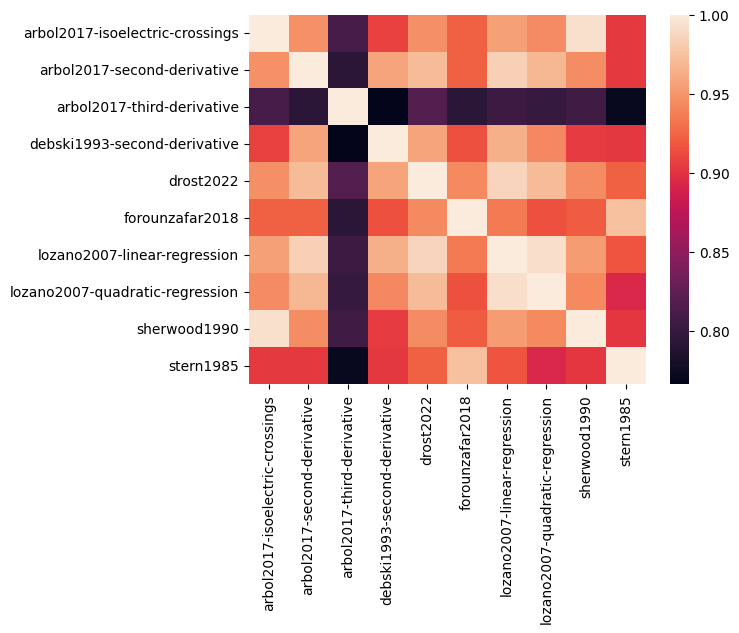

In [12]:
sns.heatmap(data=data.corr())

In [9]:
shap_per_fold = []
for fold, pipeline in enumerate(pipeline_folds):
    X_test = data.iloc[list(test_folds[fold]), :]
    estimator = pipeline[-1]
    # Create Tree Explainer object that can calculate shap values
    explainer = shap.TreeExplainer(estimator)
    shap_values_fold = np.array(explainer.shap_values(X_test))
    shap_per_fold.append(shap_values_fold)

In [14]:
shap_values = np.concatenate(shap_per_fold)

In [15]:
test_shap_values = shap_values.copy()
test_shap_values

array([[ 0.82509321,  6.21103613,  3.61540348, ..., 16.27003549,
         0.6852067 ,  9.92755334],
       [ 0.82509321,  6.21103613,  3.61540348, ..., 16.27003549,
         0.6852067 ,  9.92755334],
       [ 0.82509321,  6.21103613,  3.61540348, ..., 16.27003549,
         0.6852067 ,  9.92755334],
       ...,
       [ 1.53556522,  0.24706237,  0.45137711, ...,  6.93160974,
         1.3358541 ,  6.07427327],
       [ 1.53556522,  0.24706237,  0.45137711, ...,  6.93160974,
         1.3358541 ,  6.07427327],
       [ 1.53556522,  0.24706237,  0.45137711, ...,  6.93160974,
         1.3358541 ,  6.07427327]], shape=(10397, 10))

In [16]:
pipeline_folds[0][-1].feature_importances_

array([0.0024823 , 0.03900443, 0.00394538, 0.18260727, 0.4858298 ,
       0.0339992 , 0.20379447, 0.03836568, 0.00186108, 0.00811039])

In [17]:
feature_selector = pipeline_folds[0][-2]
feature_selector.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

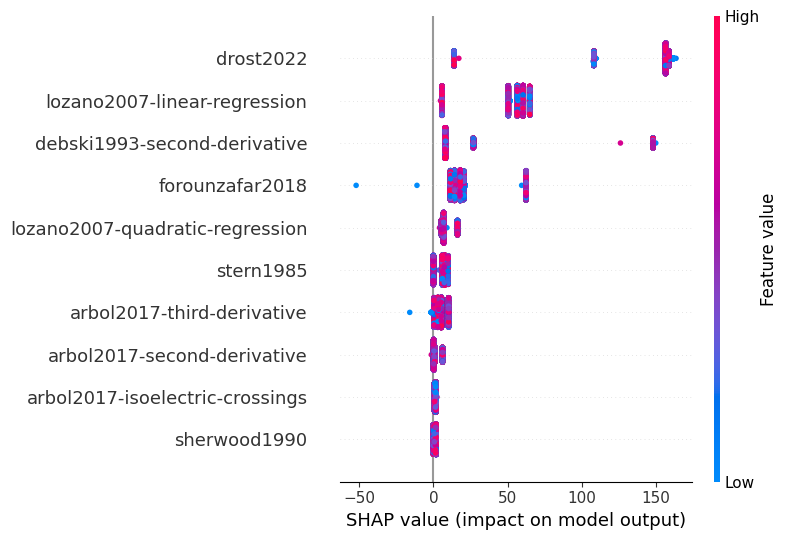

In [43]:
features = data.iloc[list(test_folds_concat), :].values
feature_names = data.columns
shap.summary_plot(
    test_shap_values, features=features, feature_names=feature_names
)

### Show summary_plot for one fold

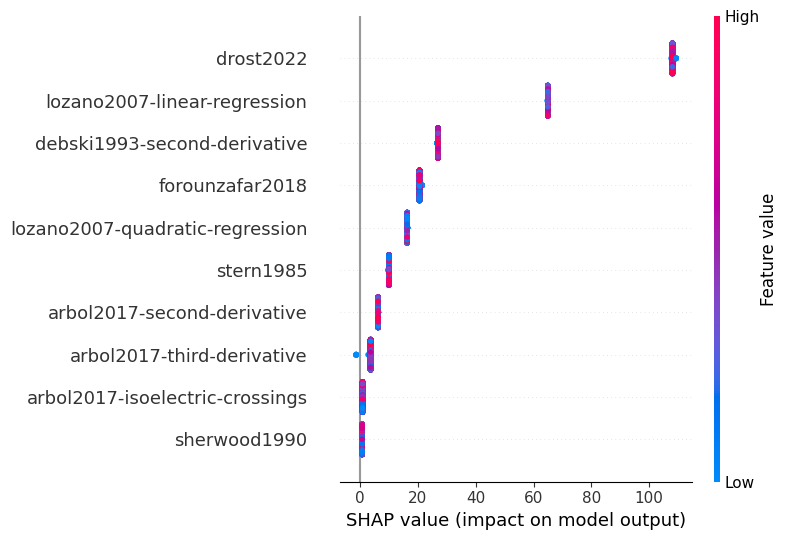

In [51]:
features = data.iloc[list(test_folds[0]), :].values
feature_names = data.columns
shap.summary_plot(
    shap_per_fold[0], features=features, feature_names=feature_names
)

In [53]:
data.iloc[list(test_folds[0]), :].describe()

,arbol2017-isoelectric-crossings,arbol2017-second-derivative,arbol2017-third-derivative,debski1993-second-derivative,drost2022,forounzafar2018,lozano2007-linear-regression,lozano2007-quadratic-regression,sherwood1990,stern1985
count,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000
mean,366.898798,323.523046,338.557615,365.808617,370.127756,340.514529,370.140782,353.999499,366.386273,333.099198
std,100.431524,110.242694,108.874383,113.511862,104.870930,109.421570,97.461884,88.319263,100.650713,108.872762
min,87.000000,108.000000,-40.000000,162.000000,143.000000,114.000000,202.000000,202.000000,162.000000,86.000000
25%,274.000000,237.000000,246.000000,269.750000,270.000000,232.000000,291.750000,280.000000,273.000000,228.000000
50%,360.000000,313.500000,338.000000,362.000000,370.000000,345.000000,364.000000,350.000000,359.000000,332.000000
75%,452.000000,416.000000,424.000000,464.000000,462.000000,440.000000,454.500000,428.000000,452.000000,432.500000
max,624.000000,602.000000,616.000000,638.000000,632.000000,742.000000,626.000000,608.000000,620.000000,622.000000


In [40]:
print(np.mean(test_shap_values[test_folds[0]], axis=0))
print(np.mean(test_shap_values[test_folds[1]], axis=0))
print(np.mean(test_shap_values[test_folds[2]], axis=0))
print(np.mean(test_shap_values[test_folds[3]], axis=0))
print(np.mean(test_shap_values[test_folds[4]], axis=0))

[  1.59622048   0.55553906   4.66011571  41.93349853 122.74094804
  26.05178767  42.16407563   6.02202973   1.13800998   4.88994915]
[  1.60896298   1.05442489   6.61053255  58.8813003  101.68162216
  33.40379999  40.61176907   7.32267338   1.03917477   4.94835661]
[  1.34266899   2.26472257   2.59561542  30.12470031 124.23490075
  20.26805941  53.70183893   9.95047156   0.96705486   6.70590249]
[  1.31244889   2.59155651   4.69782289  28.90619862 125.14373104
  22.64414787  54.28055067   9.83770417   1.16455945   7.3048664 ]
[  1.48447422   1.33249452   3.86220302  35.93768784 124.30520327
  23.43131768  47.64659549   7.76747456   1.09205217   5.78672984]


### Compute shap values for the SVR

In [ ]:
shap_per_fold_svr, test_folds_svr, pipeline_folds_svr = compute_shap_values(pipeline_permuter, data, ('StandardScaler', 'SelectFromModel', 'RandomForestRegressor'))

In [15]:
shap_values_svr = np.concatenate(shap_per_fold_svr)

In [16]:
features = data.iloc[list(np.concatenate(test_folds_svr)), :].values
feature_names = data.columns
shap.summary_plot(
    shap_values_svr, features=features, feature_names=feature_names
)

TypeError: bad operand type for abs(): 'Explanation'

<Figure size 640x480 with 0 Axes>